<a href="https://colab.research.google.com/github/rajeevfromkrec/pytorch/blob/master/Transfer_learning_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-07-31 07:57:35--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.29.60, 13.224.29.19, 13.224.29.73, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.29.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  26.5MB/s    in 1.7s    

2020-07-31 07:57:37 (26.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
!ls

hymenoptera_data.zip  sample_data


In [4]:
import zipfile
from zipfile import ZipFile

In [5]:
with ZipFile('hymenoptera_data.zip', 'r') as zipobj:
  zipobj.extractall()

In [6]:
import os
import torch
import torchvision
from torchvision import datasets,transforms ,models
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid



In [7]:
os.listdir('hymenoptera_data/train')

['ants', 'bees']

In [8]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms= tt.Compose([
                        tt.RandomResizedCrop(224),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        
])

val_tfms= tt.Compose([
                        tt.Resize(256),
                        tt.CenterCrop(224),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        
])

In [9]:
train_ds= datasets.ImageFolder('hymenoptera_data/train' ,train_tfms)
val_ds= datasets.ImageFolder('hymenoptera_data/val' ,val_tfms)

In [10]:
image,label=train_ds[0]

In [11]:
print(train_ds.classes)

['ants', 'bees']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


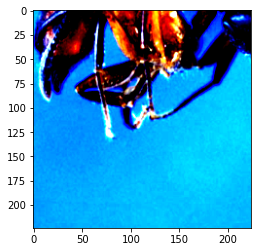

In [12]:
print(label)
plt.imshow(image.permute(1,2,0))


In [13]:
train_loader= DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=4,pin_memory=True)
val_loader= DataLoader(val_ds,batch_size=8,num_workers=4,pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 1, 1, 1, 0, 1, 0, 0])


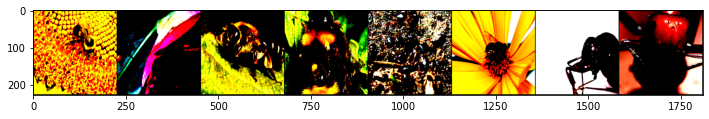

In [14]:
for images,labels in train_loader:
  print(labels)
  fig,ax=plt.subplots(figsize=(12,6))
  plt.imshow(make_grid(images,nrow=8).permute(1,2,0))
  break

In [15]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
model=models.resnet18(pretrained=True)
num_ftrs=model.fc.in_features
print(num_ftrs)
model.fc=nn.Linear(num_ftrs,2)
num_ftrs=model.fc.in_features
print(num_ftrs)

model

512
512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
for images,labels in train_loader:
  out=model(images)
  _,preds=torch.max(out,dim=1)
  print(out)
  print(preds)
  break

tensor([[ 0.5078, -0.4581],
        [ 0.2658,  0.8699],
        [ 0.4107,  0.7447],
        [-0.0839,  0.7410],
        [ 0.1396,  1.7644],
        [ 0.0335,  0.3897],
        [ 0.3108,  0.8857],
        [-0.4514,  0.7203]], grad_fn=<AddmmBackward>)
tensor([0, 1, 1, 1, 1, 1, 1, 1])


In [17]:
  def train_model(model, criterion,scheduler,num_epochs=25):
  since=time.time()

  best_model_wts=copy.deepcopy(model.state.dict())
  best_acc=0.0
  for epoch in range(num_epochs):
    print ('EPOCH {}/{}'.format(epoch,num_epochs-1))
    print ('-'*10)

    for phase in ['train', 'val']:
      if phase=='train':
        model.train()
      if phase=='val':
        model.eval()

      running_loss=0.0
      running_corrects=0

      for inputs,labels in train_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled():
          outputs=model(inputs)
          -,preds=torch.max(outputs,dim=1)
          loss=criterion(outputs,labels)
          loss.backward()
          optimizer.step()
        running_loss +=oss.item()*inputs.size(0)


IndentationError: ignored